# Homework 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Run the following cell to load in the data (make sure that you set the file paths for the data files correctly). Then, complete each section under
1. Data Preprocessing,
2. Training Phase,
3. Testing Phase, and
4. Performance Evaluation.

In [2]:
# Load data
train_trial = np.load("./data/hw4_train_trial.npy", allow_pickle=True)
test_trial = np.load("./data/hw4_test_trial.npy", allow_pickle=True)

NUM_TRAIN, NUM_DIRECTIONS = train_trial.shape
NUM_TEST = test_trial.shape[0]

## Part 1: Data Preprocessing

In [3]:
def preprocess_spikes_and_states(data: np.array):
    """
    Preprocesses train or test data. 

    Args:
        data: Either train_trial or test_trial. shape = (num_trials, num_directions). 
    Returns:
        spike_counts (np.array): spike counts in non-overlapping time bins.
        arm_states (np.array): 4-dim arm states.
    """
    # We provide empty numpy arrays as one potential data structure to store the spike counts and
    # arm states in. Here, for spike_counts, we can store a nested list of shape (97 x T) in each entry,
    # where T is the number of 20 ms time bins in the corresponding trial.
    # You are welcome to change these structures if you prefer a different implementation.
    spike_counts = np.empty(data.shape, dtype=list)
    arm_states = np.empty(data.shape, dtype=np.ndarray)

    # ----- YOUR CODE HERE ----- #
    for n in range(NUM_TRAIN):
        for k in range(NUM_DIRECTIONS):
            trial_data = train_trial[n, k]
            spikes = trial_data['spikes']
            hand_pos = trial_data['handPos']

            bins = spikes.shape[1] // 20

            binned_spikes = np.array([
                np.sum(spikes[:, i*20:(i+1)*20], axis=1)
                for i in range(bins)
            ]).T
            sampled_pos = hand_pos[:, 19::20][:, :bins]

            vel = np.diff(sampled_pos, axis=1, prepend=sampled_pos[:, [0]]) 
            vel_mps = vel * 50 / 1000

            arm_state = np.vstack((sampled_pos, vel_mps))

            spike_counts[n, k] = binned_spikes
            arm_states[n, k] = arm_state

    return spike_counts, arm_states
    # -------------------------- #

In [4]:
# save preprocessed data into variables

train_spike_counts, train_arm_states = preprocess_spikes_and_states(train_trial)
test_spike_counts, test_arm_states = preprocess_spikes_and_states(test_trial)

## Part 2: Training Phase

In [10]:
def fit_parameters(train_spike_counts: np.array, train_arm_states: np.array):
    """
    Fit the A, Pi, V, and C parameters.
    
    Args:
        train_spike_counts (np.array): spike counts in non-overlapping time bins for training data.
        train_arm_states (np.array): 4-dim arm states for training data.
    Returns:
        Model parameters {A, Pi, V, C}.
    """
    # ----- YOUR CODE HERE ----- #
    z1s = []
    z_tm1_list = []
    z_t_list = []
    x_t_list = []

    for n in range(train_arm_states.shape[0]):
        for k in range(train_arm_states.shape[1]):
            Z = train_arm_states[n, k]
            X = train_spike_counts[n, k]

            z1s.append(Z[:, 0])
            z_tm1_list.append(Z[:, :-1])
            z_t_list.append(Z[:, 1:])
            x_t_list.append(X[:, 1:])

    z1s = np.column_stack(z1s)
    Z_tm1 = np.column_stack(z_tm1_list)
    Z_t = np.column_stack(z_t_list)
    X_t = np.column_stack(x_t_list)

    pi = np.mean(z1s, axis=1)
    V = np.cov(z1s)

    A = Z_t @ Z_tm1.T @ np.linalg.inv(Z_tm1 @ Z_tm1.T)
    C = X_t @ Z_t.T @ np.linalg.inv(Z_t @ Z_t.T)

    return A, pi, V, C
    # -------------------------- #

In [11]:
def fit_qr_parameters(train_spike_counts: np.array, train_arm_states: np.array, A, C):
    """
    Fit the Q and R parameters.
    
    Args:
        train_spike_counts (np.array): spike counts in non-overlapping time bins for training data.
        train_arm_states (np.array): 4-dim arm states for training data.
        A (np.array or other): model parameter A from fit_parameter() function.
        C (np.array or other): model parameter C from fit_parameter() function.
    Returns:
        Model parameters {Q, R}.
    """
    # ----- YOUR CODE HERE ----- #
    state_residuals = []
    obs_residuals = []

    for n in range(train_arm_states.shape[0]):
        for k in range(train_arm_states.shape[1]):
            z = train_arm_states[n, k]
            x = train_spike_counts[n, k]
            T = z.shape[1]

            z_tm1 = z[:, :-1]
            z_t = z[:, 1:]
            pred_z_t = A @ z_tm1
            state_err = z_t - pred_z_t
            state_residuals.append(state_err)

            pred_x = C @ z 
            obs_err = x - pred_x
            obs_residuals.append(obs_err)

    state_residuals = np.hstack(state_residuals)
    obs_residuals = np.hstack(obs_residuals)

    Q = np.cov(state_residuals)
    R = np.cov(obs_residuals)

    return Q, R
    # -------------------------- #

In [12]:
A, Pi, V, C = fit_parameters(train_spike_counts, train_arm_states)
Q, R = fit_qr_parameters(train_spike_counts, train_arm_states, A, C)

print(f"A: {A}")
print(f"Q: {Q}")

A: [[ 9.63611058e-01 -1.60952028e-02  2.15621354e+01  1.64535690e+00]
 [ 2.02636347e-03  9.65524335e-01 -6.40528425e-01  2.15125684e+01]
 [-1.81944710e-03 -8.04760140e-04  1.07810677e+00  8.22678452e-02]
 [ 1.01318173e-04 -1.72378327e-03 -3.20264213e-02  1.07562842e+00]]
Q: [[ 7.40009698e+00 -2.07405776e-01  3.70004849e-01 -1.03702888e-02]
 [-2.07405776e-01  5.76028027e+00 -1.03702888e-02  2.88014013e-01]
 [ 3.70004849e-01 -1.03702888e-02  1.85002424e-02 -5.18514441e-04]
 [-1.03702888e-02  2.88014013e-01 -5.18514441e-04  1.44007007e-02]]


## Part 3 & 4: Test Phase and Visualization

In [18]:
def decode_arm_trajectories(test_spike_counts, test_arm_states, A, Pi, V, C):
    """
    Use model parameters previously found and apply Kalman filter to decode an arm
    trajectory for each test trial.

    Args:
        test_spike_counts (np.array): spike counts in non-overlapping time bins for test data.
        test_arm_states (np.array): 4-dim arm states for test data.
        A (np.array or other): model parameter A from fit_parameter() function.
        Pi (np.array or other): model parameter Pi from fit_parameter() function.
        V (np.array or other): model parameter V from fit_parameter() function.
        C (np.array or other): model parameter C from fit_parameter() function.
    Returns:
        test_est_state_mean (np.array): contains decoded mean position estimates.
        test_est_state_cov (np.array): contains covaraince matrices for each test trial prediction.
    """
    # We provide empty numpy arrays as one potential data structure to store the decoded mean position 
    # estimates and covariance matrices.
    # You are welcome to change these structures if you prefer a different implementation.
    test_est_state_mean = np.empty(test_spike_counts.shape, dtype=list)
    test_est_state_cov = np.empty(test_spike_counts.shape, dtype=list)

    # ----- YOUR CODE HERE ----- #
    for k in [0, 3]:
        spikes = test_spike_counts[0, k]
        T = spikes.shape[1]

        mu_t_t = Pi
        Sigma_t_t = V

        mu_pred_list = []
        Sigma_pred_list = []

        for t in range(T):
            mu_pred = A @ mu_t_t
            Sigma_pred = A @ Sigma_t_t @ A.T + Q

            mu_pred_list.append(mu_pred)
            Sigma_pred_list.append(Sigma_pred)

            mu_t_t = mu_pred
            Sigma_t_t = Sigma_pred

        test_est_state_mean[(0, k)] = np.stack(mu_pred_list, axis=1)
        test_est_state_cov[(0, k)] = Sigma_pred_list

    return test_est_state_mean, test_est_state_cov
    # -------------------------- #

In [19]:
test_est_state_mean, test_est_state_cov = decode_arm_trajectories(
    test_spike_counts,
    test_arm_states,
    A,
    Pi,
    V,
    C
)

13
12
[[-1.07642694e+01 -9.72152711e+00 -8.12833834e+00 -5.99488772e+00
  -3.35568907e+00 -2.70228693e-01  3.17740743e+00  6.87998144e+00
   1.07096434e+01  1.45215347e+01  1.81583801e+01  2.14559461e+01
   2.42491993e+01]
 [-5.70999221e+00 -5.35725324e+00 -4.84623696e+00 -4.19699118e+00
  -3.43442452e+00 -2.58710600e+00 -1.68587776e+00 -7.62346152e-01
   1.52674232e-01  1.03068388e+00  1.84690717e+00  2.58150713e+00
   3.22053284e+00]
 [ 2.52438345e-02  5.21371153e-02  7.96594389e-02  1.06672531e-01
   1.31959932e-01  1.54273019e-01  1.72381806e-01  1.85128700e-01
   1.91483096e-01  1.90594565e-01  1.81842271e-01  1.64878301e-01
   1.39662658e-01]
 [ 9.01170427e-03  1.76369485e-02  2.55508140e-02  3.24622889e-02
   3.81283333e-02  4.23659258e-02  4.50614122e-02  4.61765803e-02
   4.57510192e-02  4.39004825e-02  4.08111646e-02  3.67299976e-02
   3.19512859e-02]]


In [20]:
def plot_confidence_ellipse(M, V):
    """
    Plot a one standard-deviation ellipse for a N-dimensional Gaussian distribution.
    Arguments:
        M: mean of the Gaussian (N x 1) 
        V: Covariance matrix of the Gaussian (N x N)

    We've provided this function for you. Feel free to use it as is to help plot 
    the one standard-deviation confidence ellipse for each position estimate, modify it
    to your liking, or write your own function.

    Code adapted from EM_GM.m by Patrick P. C. Tsui.
    """
    eigenvals, eigenvecs = np.linalg.eig(V)
    d = len(M)
    if not np.any(V): # if V is array of all zeros
        V[:, :] = np.ones((d,d))  * np.finfo(float).eps
    inv_V = np.linalg.inv(V)

    # find the larger projection
    P = np.array([[1,0], [0,0]]) # X-axis projection operator
    P1 = P @ np.reshape((2 * np.sqrt(eigenvals[0]) * eigenvecs[:,0]), (2,1))
    P2 = P @ np.reshape((2 * np.sqrt(eigenvals[1]) * eigenvecs[:,1]), (2,1))
    if (np.all(np.abs(P1) >= np.abs(P2))):
        P_len = P1[0]
    else:
        P_len = P2[0]
    
    count = 0
    step = 0.001 * P_len
    contour_1 = np.zeros((2001,2))
    contour_2 = np.zeros((2001,2))

    for x in np.arange(-P_len, P_len + step, step):
        a = inv_V[1,1]
        b = x * (inv_V[0, 1] + inv_V[1, 0])
        c = x**2 * inv_V[0,0] - 1
        disc = b**2 - 4*a*c 

        if disc >= 0:
            root_1 = (-b + np.sqrt(disc)) / (2*a)
            root_2 = (-b - np.sqrt(disc)) / (2*a)
            if np.isreal(root_1):
                contour_1[count, :] = [x, root_1] + M.T
                contour_2[count, :] = [x, root_2] + M.T
                count += 1
    
    contour_1 = contour_1[0:count-1, :]
    contour_2 = np.vstack((contour_1[0], contour_2[0:count, :], contour_1[count-2, :]))

    plt.plot(M[0], M[1], 'r+')
    plt.plot(contour_1[:,0], contour_1[:,1], 'b-', linewidth=0.5)
    plt.plot(contour_2[:,0], contour_2[:,1], 'b-', linewidth=0.5)

In [37]:
def plot_trials(selected_trials: list, test_est_state_mean: np.array, test_est_state_cov: np.array, test_arm_states: np.array):
    """
    Creates a 1 x 3 plot figure for each of the trials in selected_trials.
    The subplots include 
        (1) the mean position estimate, the one-standard-deviation confidence ellipse corresponding 
        to the uncertainty of each position estimate, and the actual arm trajectory 
            - (x-axis horizontal position, y-axis vertical position);
        (2) the decoded mean trajectory in the horizontal direction, the one-standard-deviation
        confidence intervals, and the actual arm trajectory 
            - (x-axis time, y-axis horizontal position);
        (3) the decoded mean trajectory in the vertical direction, the one-standard-deviation
        confidence intervals, and the actual arm trajectory 
            - (x-axis time, y-axis vertical position)

    Argumentss:
        selected_trials (list): list of tuples indicating which trials to plot figures for.
        test_est_state_mean (np.array): decoded mean position estimates for test trials.
        test_est_state_cov (np.array): covaraince matrices for each test trial prediction.
        test_arm_states (np.array): 4-dim arm states for test data.

    We've provided a basic outline for one way you can structure this function to achieve the
    1 x 3 plot figure. You are welcome to use this outline or to change it for your implementation.
    """
    for trial, direction in selected_trials:
        # ----- YOUR CODE HERE FOR ANY VARIABLES ----- #
        est_mean = np.array(test_est_state_mean[trial, direction]).T
        est_cov = np.array(test_est_state_cov[trial, direction])
        true_states = test_arm_states[trial, direction].T  

        T = est_mean.shape[0]
        times = np.arange(T)

        plt.subplot(1,3,1)
        plt.xlabel('Horz-Pos')
        plt.ylabel('Vert-Pos')
        # ----- YOUR CODE HERE FOR SUBPLOT (1) ----- #
        plt.plot(true_states[:, 0], true_states[:, 1], 'k-')
        plt.plot(est_mean[:, 0], est_mean[:, 1], 'ro-')
        for t in range(T):
            pos_mean = est_mean[t, :2]
            pos_cov = est_cov[t, :2, :2]
            plot_confidence_ellipse(pos_mean, pos_cov)


        plt.subplot(1,3,2)
        plt.xlabel('Time')
        plt.ylabel('Horz-Pos')
        # ----- YOUR CODE HERE FOR SUBPLOT (2) ----- #
        plt.plot(times, true_states[:, 0], 'k-')
        plt.plot(times, est_mean[:, 0], 'r-')
        horz_std = np.sqrt(est_cov[:, 0, 0])
        plt.plot(times, est_mean[:, 0] - horz_std, 'r--')
        plt.plot(times, est_mean[:, 0] + horz_std, 'r--')

        
        plt.subplot(1,3,3)
        plt.xlabel('Time')
        plt.ylabel('Vert-Pos')
        # ----- YOUR CODE HERE FOR SUBPLOT (3) ----- #
        plt.plot(times, true_states[:, 1], 'k-')
        plt.plot(times, est_mean[:, 1], 'r-')
        vert_std = np.sqrt(est_cov[:, 1, 1])
        plt.plot(times, est_mean[:, 1] - vert_std, 'r--')
        plt.plot(times, est_mean[:, 1] + vert_std, 'r--')

        # ----- YOUR CODE HERE FOR ANY ADDITIONAL WORK OR PLOT STYLING ----- #

        plt.tight_layout()
        plt.show()

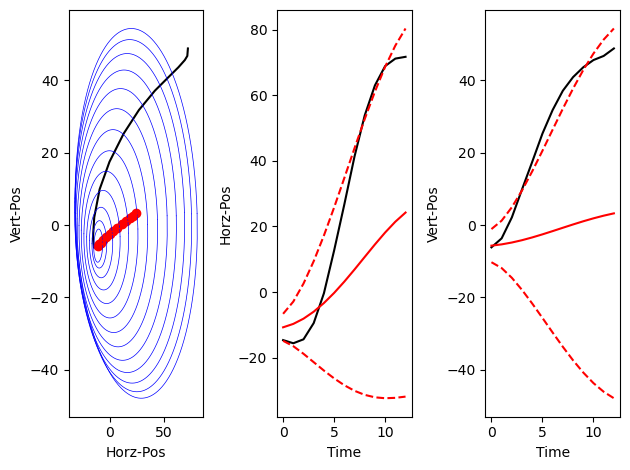

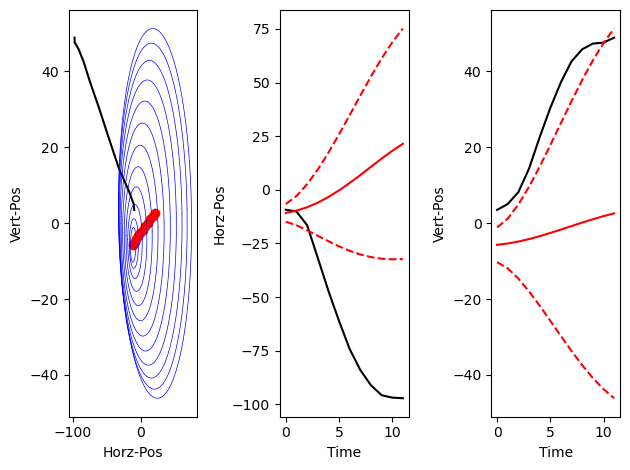

In [38]:
selected_trials = [(0,0), (0,3)]
plot_trials(selected_trials, test_est_state_mean, test_est_state_cov, test_arm_states)

## Part 5: Performance Evaluation

In [ ]:
def calculate_distance(test_arm_states: np.array, test_est_state_mean: np.array):
    """
    Calculates the mean distance (in mm) between the decoded position and actual position
    across the timepoints of all test trials.

    Args: 
        test_arm_states (np.array): 4-dim arm states for test data.
        test_est_state_mean (np.array): decoded mean position estimates for test trials.
    Returns:
        dist (float): mean distance.
    """
    # ----- YOUR CODE HERE ----- #
    raise NotImplementedError
    # -------------------------- #

In [ ]:
dist = calculate_distance(test_arm_states, test_est_state_mean)
print(f"Mean distance error: {dist:.4f} mm")

### Administrative (2 pts)

About how many hours did you spend on this homework? There is no right or wrong answer :-)